In [1]:
from pymavlink import mavutil
import math
import tkinter as tk
import socket
import time
import helper
import threading
import torch
import torch.nn as nn
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
SIM_COMPUTER_IP = '192.168.1.124'  # IP address of the simulation computer
PORT = 15000  # The same port as used by the server

In [3]:
def send_command(command):
    with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
        s.connect((SIM_COMPUTER_IP, PORT))
        s.sendall(command.encode('utf-8'))

def start_instance(instance_id, out_port):
    send_command(f"start {instance_id} {out_port}")

def stop_instance(instance_id):
    send_command(f"stop {instance_id}")

def connect(port):
    connection = mavutil.mavlink_connection(f'udpin:0.0.0.0:{port}') 

    connection.wait_heartbeat() #wait until we hear a heartbeat from the copter

    return connection 

def get_current_position(connection):

    msg = connection.recv_match(type='LOCAL_POSITION_NED', blocking=True)

    north = msg.x
    east = msg.y
    down = -msg.z

    return(north, east, down)

def wait_for_gps_lock(connection, timeout=60):
    start_time = time.time()
    while True:
        # Check for timeout
        if time.time() - start_time > timeout:
            print("Timeout waiting for GPS lock.")
            return False
            
        # Fetch GPS_RAW_INT messages
        msg = connection.recv_match(type='GPS_RAW_INT', blocking=True, timeout=5)
        if not msg:
            print("No GPS data received.")
            continue
            
        # Check for 3D lock
        if msg.fix_type >= 3:
            print(f"GPS lock acquired with {msg.satellites_visible} satellites.")
            return True
        else:
            print(f"Current GPS fix type: {msg.fix_type}, waiting for 3D lock...")

        time.sleep(1)


def arm(mavlink_connection):
    """
    Arms vehicle and fly to a target altitude.
    :param mavlink_connection: The connection to the vehicle
    :param target_altitude: Target altitude in meters
    """

    print("Basic pre-arm checks")
    # Wait for vehicle to initialize and become ready
    while not mavlink_connection.wait_heartbeat(timeout=5):
        print("Waiting for vehicle heartbeat")

           
    print("Setting vehicle to GUIDED mode")
    mavlink_connection.mav.set_mode_send(mavlink_connection.target_system, mavutil.mavlink.MAV_MODE_FLAG_CUSTOM_MODE_ENABLED, 4) 

    # Wait a bit for the mode to change
    time.sleep(2)

    # Copter should arm in GUIDED mode
    mavlink_connection.mav.command_long_send(
        mavlink_connection.target_system, mavlink_connection.target_component,
        mavutil.mavlink.MAV_CMD_COMPONENT_ARM_DISARM,
        0,  # Confirmation
        1,  # 1 to arm
        0, 0, 0, 0, 0, 0  # Unused parameters for this command
    )
def waitForEKF2(connection):
    while True:
        msg = connection.recv_match(type='STATUSTEXT', blocking=True, timeout=5)
        if msg is None:
            continue
        text = msg.text.decode('utf-8')
        if "EKF2 IMU0 is using GPS" in text:
            print("Received EKF2 GPS lock message.")
            return True

def takeoff(mavlink_connection, alt):
    #Assumes you have already set to guided mode and armed.

    mavlink_connection.mav.command_long_send(mavlink_connection.target_system, mavlink_connection.target_component, 
                                 mavutil.mavlink.MAV_CMD_NAV_TAKEOFF, 0, 0, 0, 0, 0, 0, 0, alt)
    
    #See how the copter responded to the takeoff command
    msg = mavlink_connection.recv_match(type = 'COMMAND_ACK', blocking = True)
    print(msg)

    while True:
        # Wait for the next LOCAL_POSITION_NED message
        msg = mavlink_connection.recv_match(type='LOCAL_POSITION_NED', blocking=True)
        
    
        # Check if altitude is within a threshold of the target altitude
        if abs(msg.z * -1 - alt) < 1.0:
            print("Reached target altitude")
            break

#send local frame coordinates and have copter fly over that spot.
def send_waypoint_local(connection, x, y, alt):
    connection.mav.send(mavutil.mavlink.MAVLink_set_position_target_local_ned_message
                    (10, connection.target_system, connection.target_component, mavutil.mavlink.MAV_FRAME_LOCAL_NED, 
                     int(0b010111111000), x, y, alt,
                      0, 0, 0, 0, 0, 0, 0, 0))

    time.sleep(1)


In [4]:
def plot_3d_paths(results):
    # Create a new figure for plotting
    fig = plt.figure(figsize=(10, 8))
    
    # Determine the number of subplots based on the number of paths
    num_paths = len(results)
    cols = 2  # You can adjust the number of columns based on your preference
    rows = (num_paths + cols - 1) // cols  # Calculate rows needed
    
    # Plot each path in a subplot
    for index, (pid, path) in enumerate(results.items(), start=1):
        ax = fig.add_subplot(rows, cols, index, projection='3d')
        # Assuming path is a list of [north, east, down] coordinates
        path = np.array(path)  # Convert path to a NumPy array for easier slicing
        ax.plot(path[:, 0], path[:, 1], path[:, 2], marker='o')  # Plot the 3D path
        ax.plot(5, 5, 9, marker = 'o', color='red')
        
        ax.set_xlabel('North')
        ax.set_ylabel('East')
        ax.set_zlabel('Down')
        ax.set_title(f'PID {pid} Flight Path')

    plt.tight_layout()
    plt.show()

In [5]:
# GANN definitions #

class DroneNet(nn.Module):
    def __init__(self):
        super(DroneNet, self).__init__()
        self.fc1 = nn.Linear(3, 10)  # First hidden layer from 3 inputs to 10 nodes
        self.fc2 = nn.Linear(10, 5)  # Second hidden layer from 10 nodes to 5 nodes
        self.output = nn.Linear(5, 3)  # Output layer from 5 nodes to 3 outputs (NED coordinates)

    def forward(self, x):
        x = torch.relu(self.fc1(x))  # Activation function for first hidden layer
        x = torch.relu(self.fc2(x))  # Activation function for second hidden layer
        x = self.output(x)  # Output layer, no activation (linear output)
        return x
    
def get_fitness(path, target):
    # calculate how close final position was to target and the total distance.
    # return a fitness that rewards closeness to target and minumum distance flown.
    final_position = path[-1]
    fp_north, fp_east, fp_down = final_position
    t_north, t_east, t_down = target

    distance_from_target = np.sqrt((fp_north-t_north)**2 + (fp_east-t_east)**2 + (fp_down-t_down)**2)

    total_distance = 0
    for i in range(1, len(path)):
        n, e, d = path[i]
        old_n, old_e, old_d = path[i-1]

        total_distance += np.sqrt((old_n-n)**2 + (old_e-e)**2 + (old_d-d)**2)
    
    fitness = 1 / (distance_from_target + 1) + 1 / (total_distance + 1)
    return fitness

def mutate(network, mutation_rate=0.1, mutation_strength=0.1):
    with torch.no_grad():
        for param in network.parameters():
            if random.random() < mutation_rate:
                mutation = torch.randn_like(param) * mutation_strength
                param.add_(mutation)

def crossover(parent1, parent2):
    child = DroneNet()  # Assuming DroneNet is the class of your network
    with torch.no_grad():
        for child_param, param1, param2 in zip(child.parameters(), parent1.parameters(), parent2.parameters()):
            mask = torch.bernoulli(torch.full_like(param1, 0.5))  # Randomly take weights from either parent
            child_param.data.copy_(param1.data * mask + param2.data * (1 - mask))
    return child

def initialize_population(size):
    return [DroneNet() for _ in range(size)]

def generate_new_population(population, fitness_scores, mutation_rate, mutation_strength):
    new_population = []
    population_size = len(population)
    
    # Select the best half from the population
    sorted_indices = sorted(range(len(fitness_scores)), key=lambda k: fitness_scores[k], reverse=True)
    elite = [population[i] for i in sorted_indices[:population_size // 2]]

    # Crossover and mutation to fill the new population
    while len(new_population) < population_size - len(elite):
        parent1, parent2 = random.sample(elite, 2)
        child = crossover(parent1, parent2)
        mutate(child, mutation_rate, mutation_strength)
        new_population.append(child)

    # Ensure that the total new population size does not exceed the original population size
    new_population.extend(elite[:population_size - len(new_population)])

    return new_population


<----------------------- EPOCH 0 ------------------------->
starting instance 0 on port 14560
starting instance 1 on port 14561
starting instance 2 on port 14562
starting instance 3 on port 14563
instance 1 - Heartbeat Recieved!instance 0 - Heartbeat Recieved!

instance 3 - Heartbeat Recieved!
instance 2 - Heartbeat Recieved!
instance 1 - arming throttle in GUIDED mode.instance 0 - arming throttle in GUIDED mode.
Basic pre-arm checks

Basic pre-arm checks
Setting vehicle to GUIDED mode
Setting vehicle to GUIDED mode
instance 3 - arming throttle in GUIDED mode.
Basic pre-arm checks
Setting vehicle to GUIDED mode
instance 2 - arming throttle in GUIDED mode.
Basic pre-arm checks
Setting vehicle to GUIDED mode
instance 1 - sending takeoff commandinstance 0 - sending takeoff command

instance 3 - sending takeoff command
COMMAND_ACK {command : 410, result : 4, progress : 0, result_param2 : 0, target_system : 0, target_component : 0}
instance 2 - sending takeoff command
COMMAND_ACK {command :

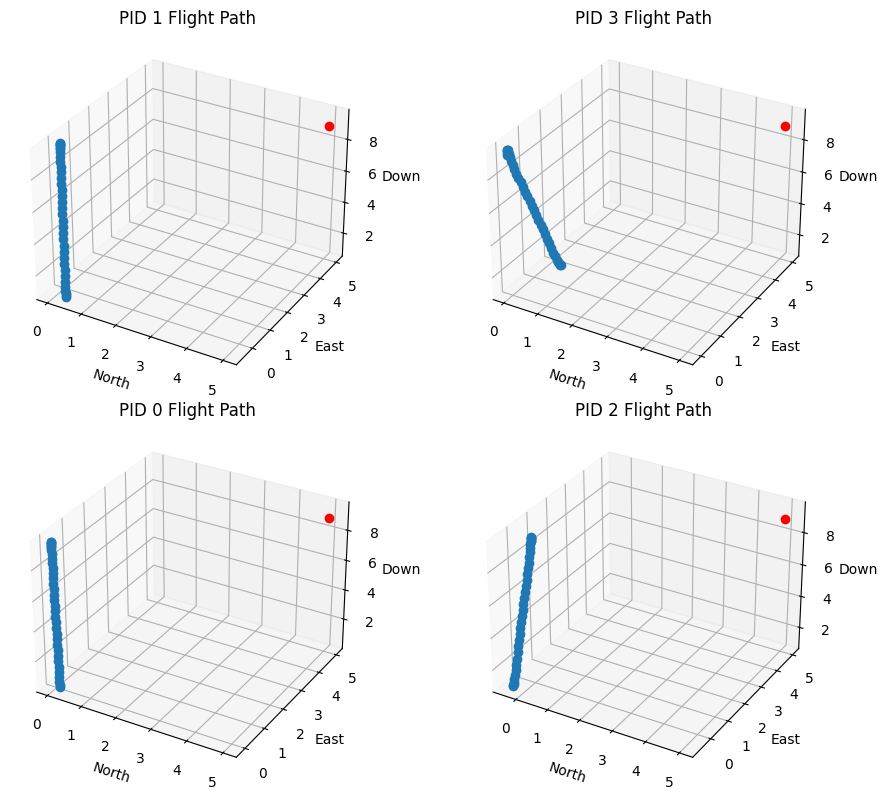

Before update: 4
After update: 4
<----------------------- EPOCH 1 ------------------------->
starting instance 4 on port 14564
starting instance 5 on port 14565
starting instance 6 on port 14566
starting instance 7 on port 14567
instance 6 - Heartbeat Recieved!
instance 4 - Heartbeat Recieved!
instance 7 - Heartbeat Recieved!
instance 5 - Heartbeat Recieved!
instance 6 - arming throttle in GUIDED mode.
Basic pre-arm checks
Setting vehicle to GUIDED mode
instance 4 - arming throttle in GUIDED mode.
Basic pre-arm checks
Setting vehicle to GUIDED mode
instance 7 - arming throttle in GUIDED mode.
Basic pre-arm checks
Setting vehicle to GUIDED mode
instance 5 - arming throttle in GUIDED mode.
Basic pre-arm checks
Setting vehicle to GUIDED mode
instance 6 - sending takeoff command
COMMAND_ACK {command : 410, result : 4, progress : 0, result_param2 : 0, target_system : 0, target_component : 0}
instance 4 - sending takeoff command
instance 7 - sending takeoff command
instance 5 - sending takeo

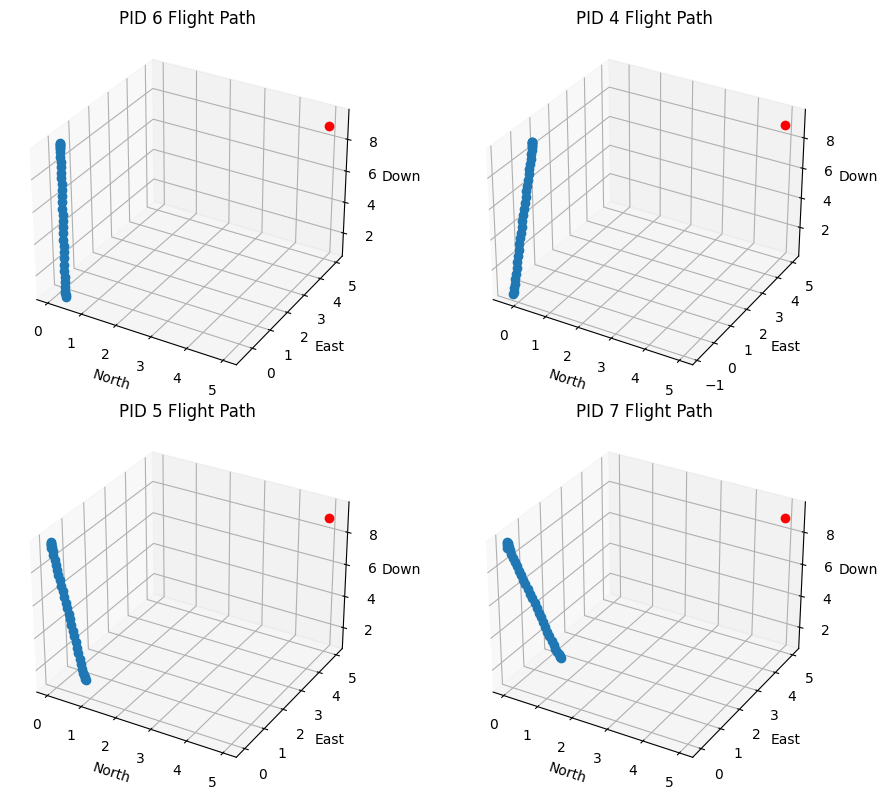

Before update: 4
After update: 4
<----------------------- EPOCH 2 ------------------------->
starting instance 8 on port 14568
starting instance 9 on port 14569
starting instance 10 on port 14570
starting instance 11 on port 14571
instance 8 - Heartbeat Recieved!instance 11 - Heartbeat Recieved!

instance 9 - Heartbeat Recieved!
instance 10 - Heartbeat Recieved!
instance 8 - arming throttle in GUIDED mode.instance 11 - arming throttle in GUIDED mode.
Basic pre-arm checks

Basic pre-arm checks
Setting vehicle to GUIDED mode
Setting vehicle to GUIDED mode
instance 9 - arming throttle in GUIDED mode.
Basic pre-arm checks
Setting vehicle to GUIDED mode
instance 10 - arming throttle in GUIDED mode.
Basic pre-arm checks
Setting vehicle to GUIDED mode
instance 8 - sending takeoff commandinstance 11 - sending takeoff command

instance 9 - sending takeoff command
instance 10 - sending takeoff command
COMMAND_ACK {command : 410, result : 4, progress : 0, result_param2 : 0, target_system : 0, tar

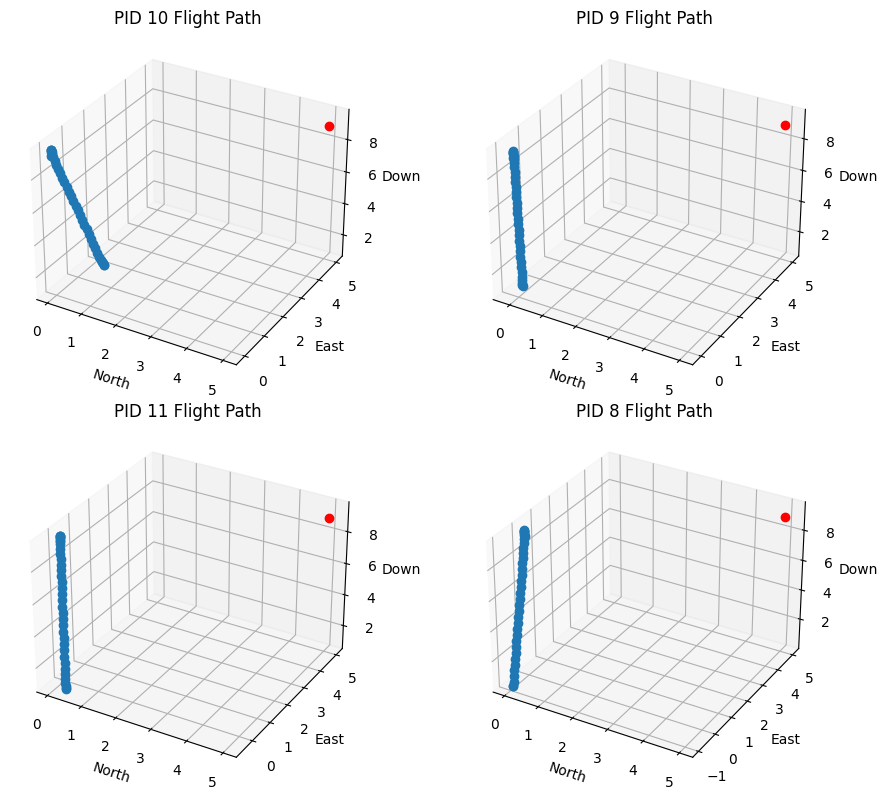

Before update: 4
After update: 4
<----------------------- EPOCH 3 ------------------------->
starting instance 12 on port 14572
starting instance 13 on port 14573
starting instance 14 on port 14574
starting instance 15 on port 14575
instance 12 - Heartbeat Recieved!instance 13 - Heartbeat Recieved!

instance 15 - Heartbeat Recieved!
instance 14 - Heartbeat Recieved!
instance 12 - arming throttle in GUIDED mode.instance 13 - arming throttle in GUIDED mode.
Basic pre-arm checks

Basic pre-arm checks
instance 15 - arming throttle in GUIDED mode.
Basic pre-arm checks
Setting vehicle to GUIDED mode
Setting vehicle to GUIDED mode
Setting vehicle to GUIDED mode
instance 14 - arming throttle in GUIDED mode.
Basic pre-arm checks
Setting vehicle to GUIDED mode
instance 12 - sending takeoff command
instance 15 - sending takeoff command
instance 13 - sending takeoff command
COMMAND_ACK {command : 410, result : 4, progress : 0, result_param2 : 0, target_system : 0, target_component : 0}
instance 14

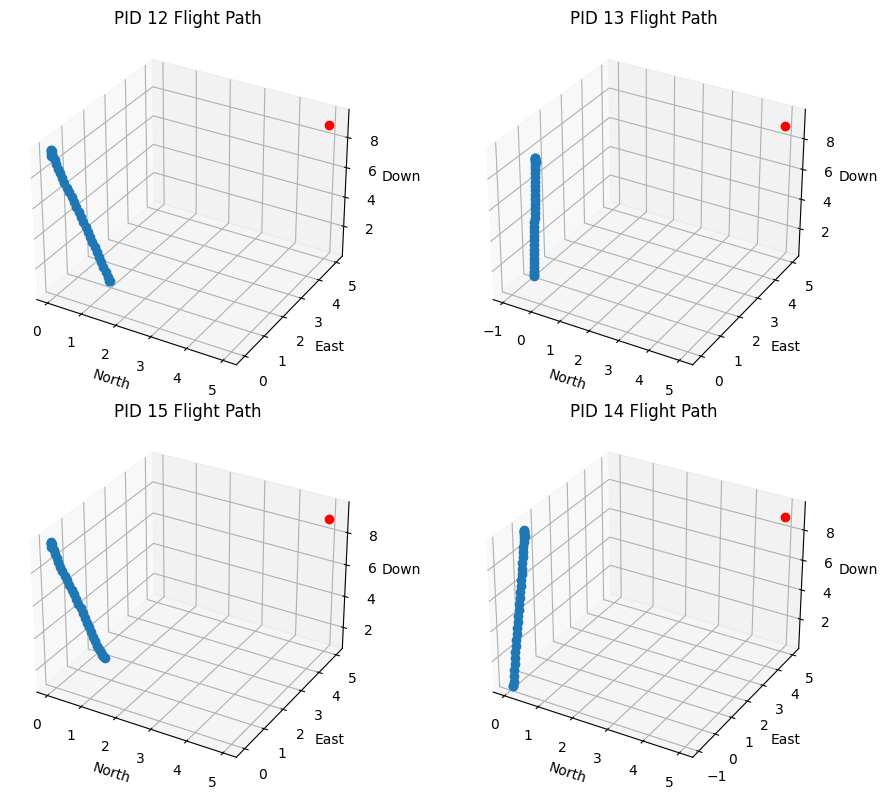

Before update: 4
After update: 4
<----------------------- EPOCH 4 ------------------------->
starting instance 16 on port 14576
starting instance 17 on port 14577
starting instance 18 on port 14578
starting instance 19 on port 14579
instance 16 - Heartbeat Recieved!
instance 18 - Heartbeat Recieved!
instance 17 - Heartbeat Recieved!
instance 19 - Heartbeat Recieved!
instance 16 - arming throttle in GUIDED mode.
Basic pre-arm checks
Setting vehicle to GUIDED mode
instance 18 - arming throttle in GUIDED mode.
Basic pre-arm checks
Setting vehicle to GUIDED mode
instance 17 - arming throttle in GUIDED mode.
Basic pre-arm checks
Setting vehicle to GUIDED mode
instance 19 - arming throttle in GUIDED mode.
Basic pre-arm checks
Setting vehicle to GUIDED mode
instance 16 - sending takeoff command
COMMAND_ACK {command : 410, result : 4, progress : 0, result_param2 : 0, target_system : 0, target_component : 0}
instance 17 - sending takeoff command
instance 18 - sending takeoff command
instance 19

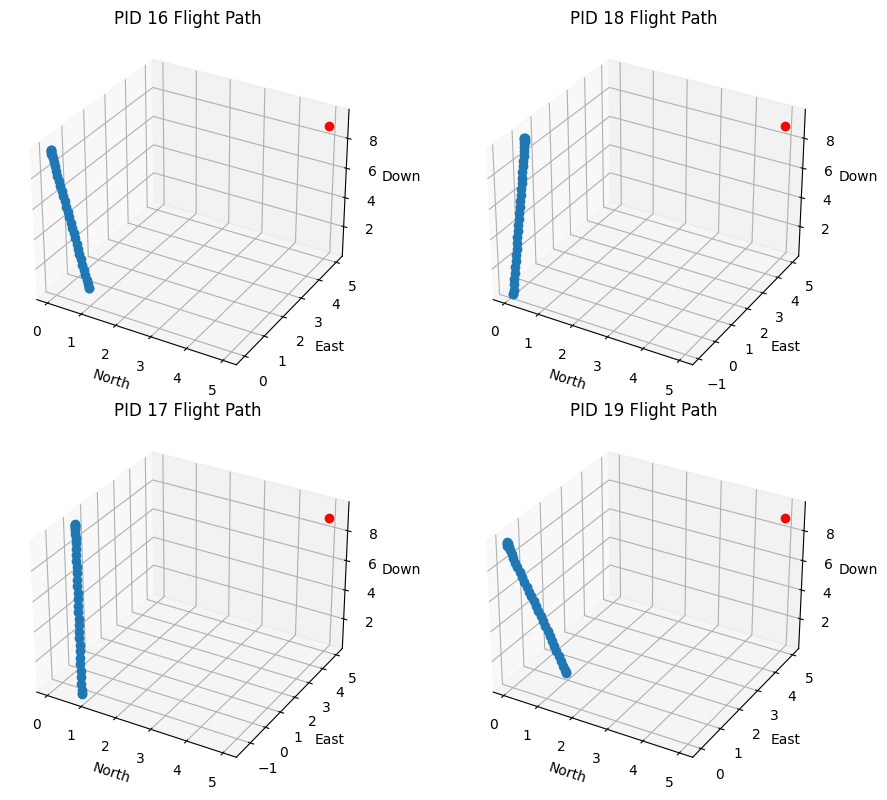

Before update: 4
After update: 4
<----------------------- EPOCH 5 ------------------------->
starting instance 20 on port 14580
starting instance 21 on port 14581
starting instance 22 on port 14582
starting instance 23 on port 14583
instance 21 - Heartbeat Recieved!
instance 22 - Heartbeat Recieved!
instance 20 - Heartbeat Recieved!
instance 23 - Heartbeat Recieved!
instance 21 - arming throttle in GUIDED mode.
Basic pre-arm checks
Setting vehicle to GUIDED mode
instance 22 - arming throttle in GUIDED mode.
Basic pre-arm checks
Setting vehicle to GUIDED mode
instance 20 - arming throttle in GUIDED mode.
Basic pre-arm checks
Setting vehicle to GUIDED mode
instance 23 - arming throttle in GUIDED mode.
Basic pre-arm checks
Setting vehicle to GUIDED mode
instance 21 - sending takeoff commandinstance 22 - sending takeoff command

COMMAND_ACK {command : 410, result : 4, progress : 0, result_param2 : 0, target_system : 0, target_component : 0}
COMMAND_ACK {command : 410, result : 4, progress 

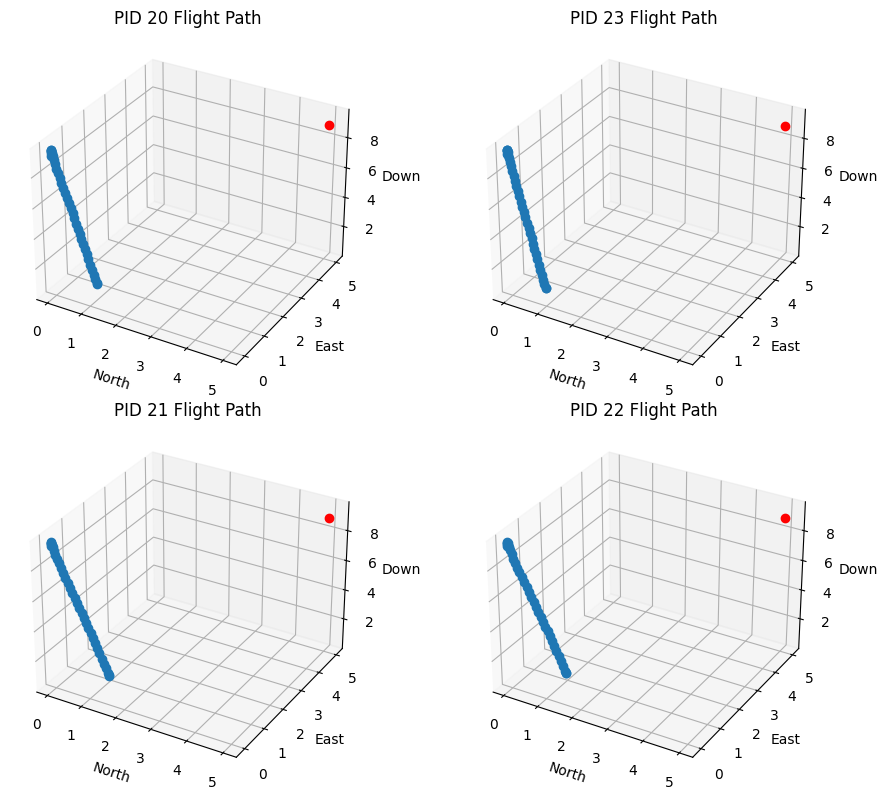

Before update: 4
After update: 4
<----------------------- EPOCH 6 ------------------------->
starting instance 24 on port 14584
starting instance 25 on port 14585
starting instance 26 on port 14586
starting instance 27 on port 14587
instance 27 - Heartbeat Recieved!
instance 24 - Heartbeat Recieved!
instance 26 - Heartbeat Recieved!
instance 25 - Heartbeat Recieved!
instance 27 - arming throttle in GUIDED mode.
Basic pre-arm checks
Setting vehicle to GUIDED mode
instance 24 - arming throttle in GUIDED mode.
Basic pre-arm checks
Setting vehicle to GUIDED mode
instance 26 - arming throttle in GUIDED mode.
Basic pre-arm checks
Setting vehicle to GUIDED mode
instance 25 - arming throttle in GUIDED mode.
Basic pre-arm checks
Setting vehicle to GUIDED mode
instance 27 - sending takeoff command
COMMAND_ACK {command : 410, result : 4, progress : 0, result_param2 : 0, target_system : 0, target_component : 0}
instance 24 - sending takeoff command
instance 26 - sending takeoff command
instance 25

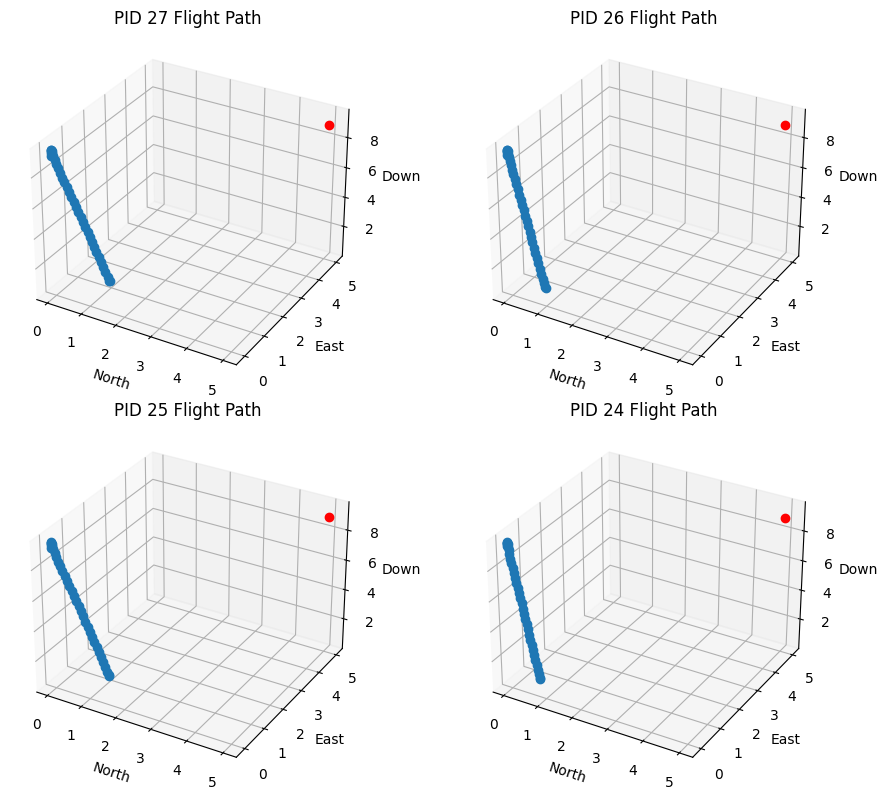

Before update: 4
After update: 4
<----------------------- EPOCH 7 ------------------------->
starting instance 28 on port 14588
starting instance 29 on port 14589
starting instance 30 on port 14590
starting instance 31 on port 14591
instance 28 - Heartbeat Recieved!
instance 31 - Heartbeat Recieved!
instance 30 - Heartbeat Recieved!
instance 29 - Heartbeat Recieved!
instance 28 - arming throttle in GUIDED mode.instance 31 - arming throttle in GUIDED mode.
Basic pre-arm checks

Basic pre-arm checks
Setting vehicle to GUIDED mode
Setting vehicle to GUIDED mode
instance 30 - arming throttle in GUIDED mode.
Basic pre-arm checks
Setting vehicle to GUIDED mode
instance 29 - arming throttle in GUIDED mode.
Basic pre-arm checks
Setting vehicle to GUIDED mode
instance 28 - sending takeoff commandinstance 31 - sending takeoff command

COMMAND_ACK {command : 410, result : 4, progress : 0, result_param2 : 0, target_system : 0, target_component : 0}
instance 30 - sending takeoff command
instance 29

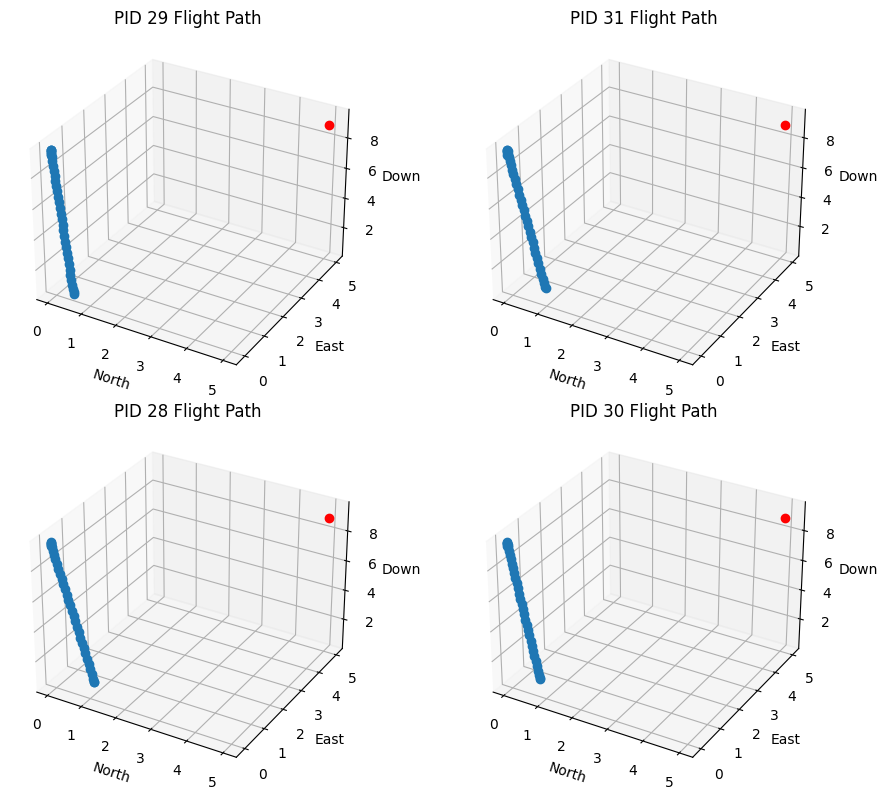

Before update: 4
After update: 4
<----------------------- EPOCH 8 ------------------------->
starting instance 32 on port 14592
starting instance 33 on port 14593
starting instance 34 on port 14594
starting instance 35 on port 14595
instance 33 - Heartbeat Recieved!
instance 35 - Heartbeat Recieved!
instance 32 - Heartbeat Recieved!
instance 34 - Heartbeat Recieved!
instance 35 - arming throttle in GUIDED mode.instance 33 - arming throttle in GUIDED mode.
Basic pre-arm checks

Basic pre-arm checks
Setting vehicle to GUIDED mode
Setting vehicle to GUIDED mode
instance 32 - arming throttle in GUIDED mode.
Basic pre-arm checks
Setting vehicle to GUIDED mode
instance 34 - arming throttle in GUIDED mode.
Basic pre-arm checks
Setting vehicle to GUIDED mode
instance 35 - sending takeoff command
instance 33 - sending takeoff command
COMMAND_ACK {command : 410, result : 4, progress : 0, result_param2 : 0, target_system : 0, target_component : 0}
instance 34 - sending takeoff command
instance 32

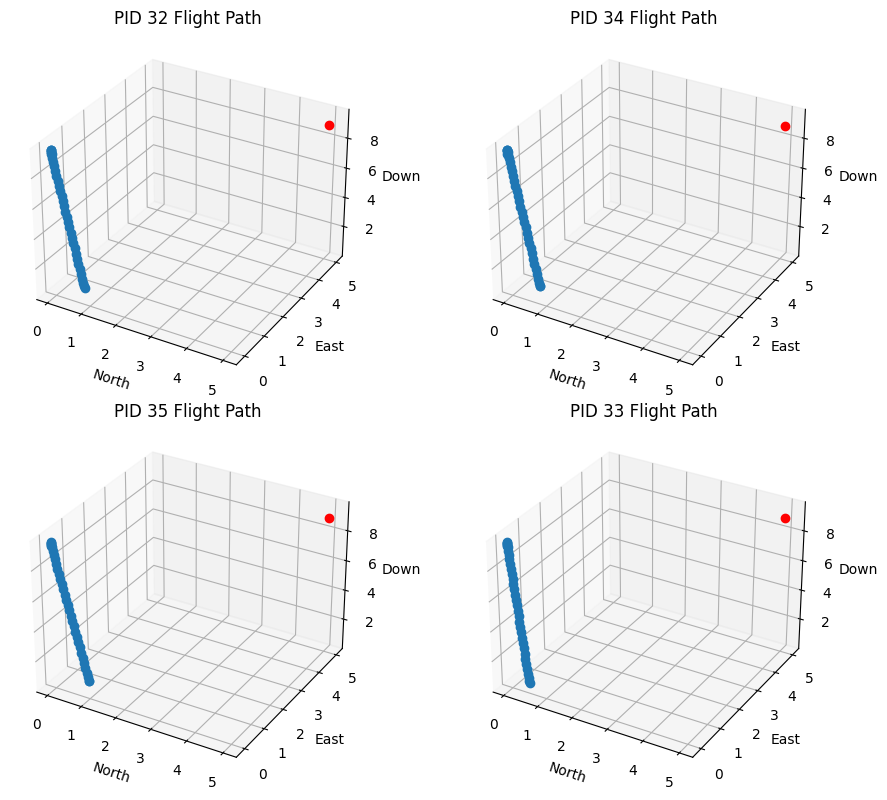

Before update: 4
After update: 4
<----------------------- EPOCH 9 ------------------------->
starting instance 36 on port 14596
starting instance 37 on port 14597
starting instance 38 on port 14598
starting instance 39 on port 14599
instance 38 - Heartbeat Recieved!
instance 36 - Heartbeat Recieved!
instance 39 - Heartbeat Recieved!
instance 37 - Heartbeat Recieved!
instance 38 - arming throttle in GUIDED mode.
Basic pre-arm checks
Setting vehicle to GUIDED mode
instance 36 - arming throttle in GUIDED mode.
Basic pre-arm checks
Setting vehicle to GUIDED mode
instance 39 - arming throttle in GUIDED mode.
Basic pre-arm checks
instance 37 - arming throttle in GUIDED mode.
Basic pre-arm checks
Setting vehicle to GUIDED mode
Setting vehicle to GUIDED mode
instance 38 - sending takeoff command
instance 36 - sending takeoff command
COMMAND_ACK {command : 410, result : 4, progress : 0, result_param2 : 0, target_system : 0, target_component : 0}
instance 39 - sending takeoff command
instance 37

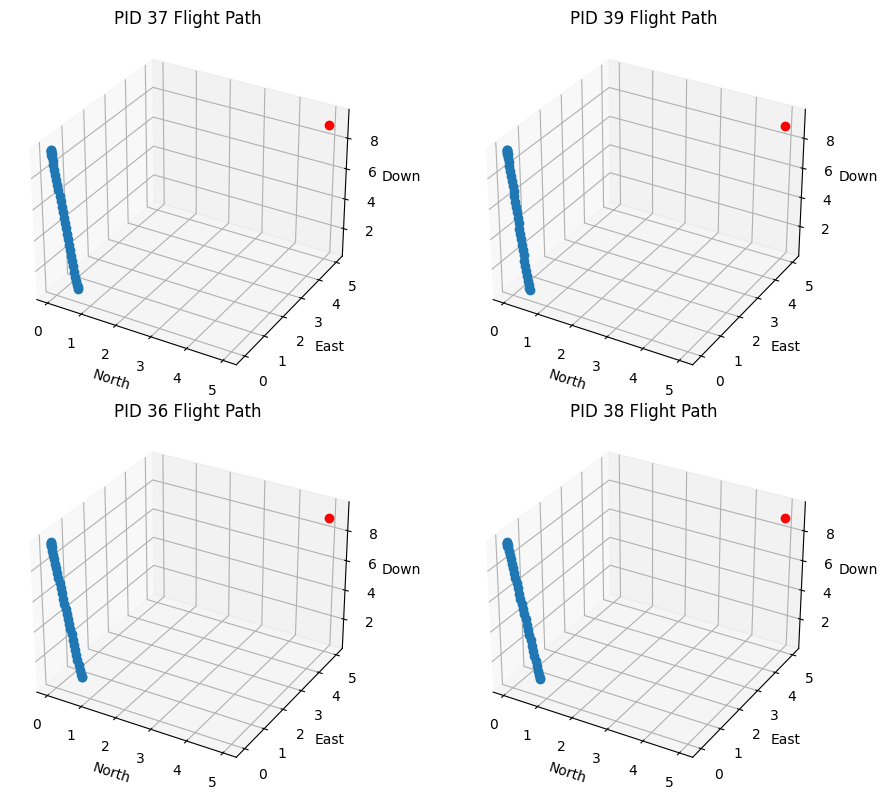

Before update: 4
After update: 4
<----------------------- EPOCH 10 ------------------------->
starting instance 40 on port 14600
starting instance 41 on port 14601
starting instance 42 on port 14602
starting instance 43 on port 14603
instance 40 - Heartbeat Recieved!
instance 42 - Heartbeat Recieved!
instance 43 - Heartbeat Recieved!
instance 41 - Heartbeat Recieved!
instance 42 - arming throttle in GUIDED mode.instance 40 - arming throttle in GUIDED mode.
Basic pre-arm checks
instance 43 - arming throttle in GUIDED mode.
Basic pre-arm checks

Basic pre-arm checks
Setting vehicle to GUIDED mode
Setting vehicle to GUIDED mode
Setting vehicle to GUIDED mode
instance 41 - arming throttle in GUIDED mode.
Basic pre-arm checks
Setting vehicle to GUIDED mode
instance 42 - sending takeoff commandinstance 40 - sending takeoff command

instance 43 - sending takeoff command
instance 41 - sending takeoff command
COMMAND_ACK {command : 410, result : 4, progress : 0, result_param2 : 0, target_system

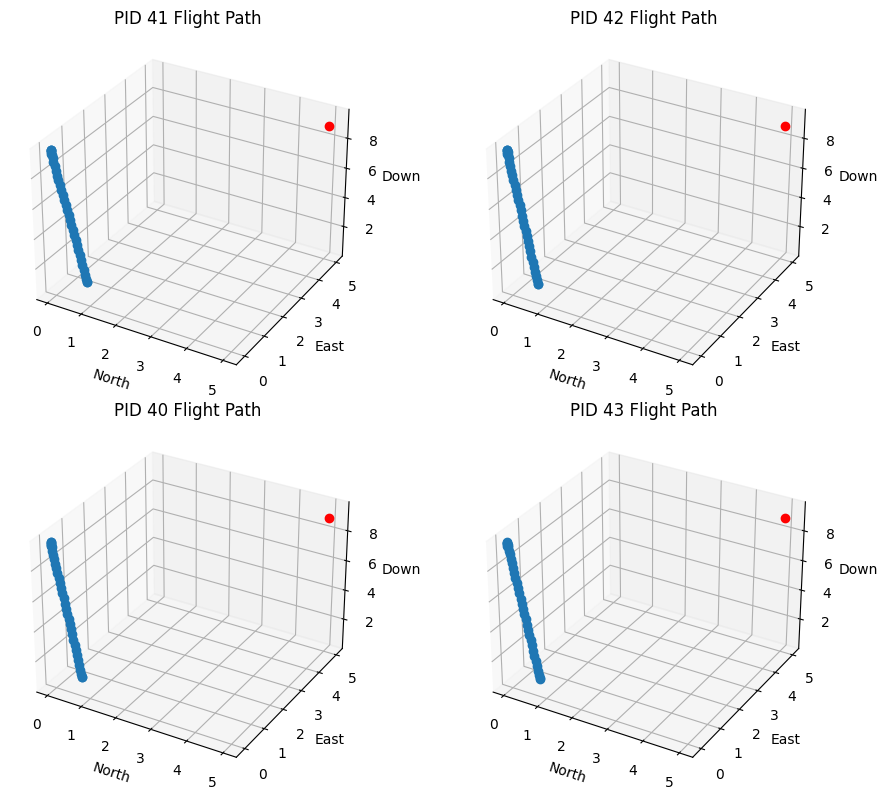

Before update: 4
After update: 4
<----------------------- EPOCH 11 ------------------------->
starting instance 44 on port 14604
starting instance 45 on port 14605
starting instance 46 on port 14606
starting instance 47 on port 14607
instance 47 - Heartbeat Recieved!
instance 45 - Heartbeat Recieved!
instance 46 - Heartbeat Recieved!
instance 44 - Heartbeat Recieved!
instance 47 - arming throttle in GUIDED mode.
Basic pre-arm checks
Setting vehicle to GUIDED mode
instance 45 - arming throttle in GUIDED mode.
Basic pre-arm checks
Setting vehicle to GUIDED mode
instance 46 - arming throttle in GUIDED mode.
Basic pre-arm checks
Setting vehicle to GUIDED mode
instance 44 - arming throttle in GUIDED mode.
Basic pre-arm checks
Setting vehicle to GUIDED mode
instance 45 - sending takeoff commandinstance 47 - sending takeoff command

COMMAND_ACK {command : 410, result : 4, progress : 0, result_param2 : 0, target_system : 0, target_component : 0}
instance 46 - sending takeoff command
instance 4

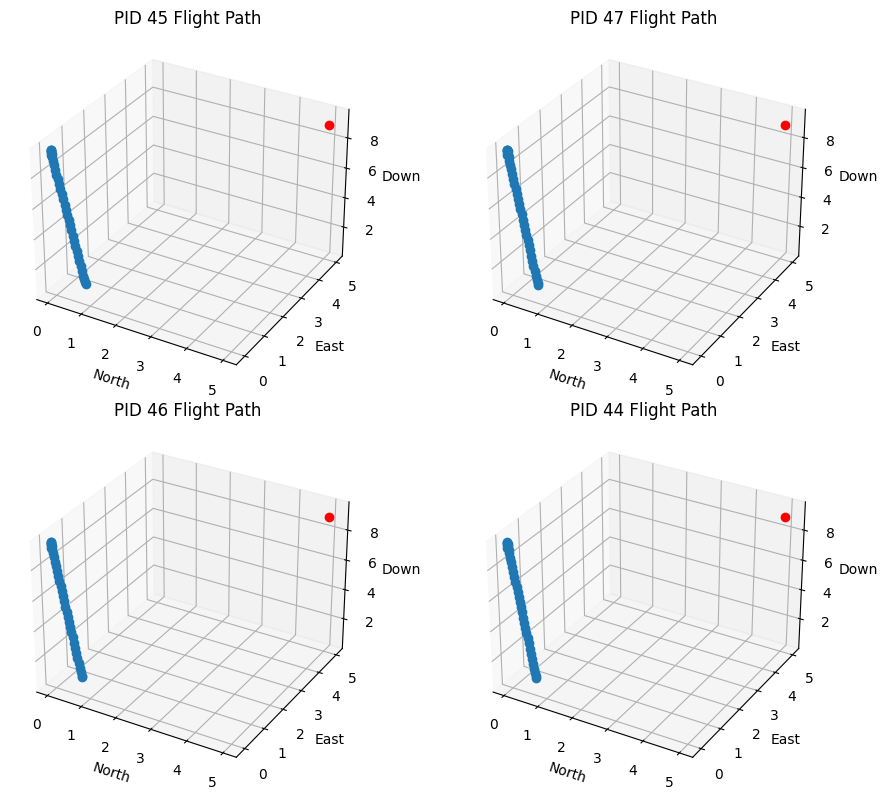

Before update: 4
After update: 4
<----------------------- EPOCH 12 ------------------------->
starting instance 48 on port 14608
starting instance 49 on port 14609
starting instance 50 on port 14610
starting instance 51 on port 14611
instance 50 - Heartbeat Recieved!
instance 49 - Heartbeat Recieved!
instance 48 - Heartbeat Recieved!
instance 51 - Heartbeat Recieved!
instance 50 - arming throttle in GUIDED mode.
Basic pre-arm checks
Setting vehicle to GUIDED mode
instance 49 - arming throttle in GUIDED mode.
Basic pre-arm checks
Setting vehicle to GUIDED mode
instance 48 - arming throttle in GUIDED mode.
Basic pre-arm checks
Setting vehicle to GUIDED mode
instance 51 - arming throttle in GUIDED mode.
Basic pre-arm checks
Setting vehicle to GUIDED mode
instance 50 - sending takeoff command
COMMAND_ACK {command : 410, result : 4, progress : 0, result_param2 : 0, target_system : 0, target_component : 0}
instance 49 - sending takeoff command
instance 48 - sending takeoff command
instance 5

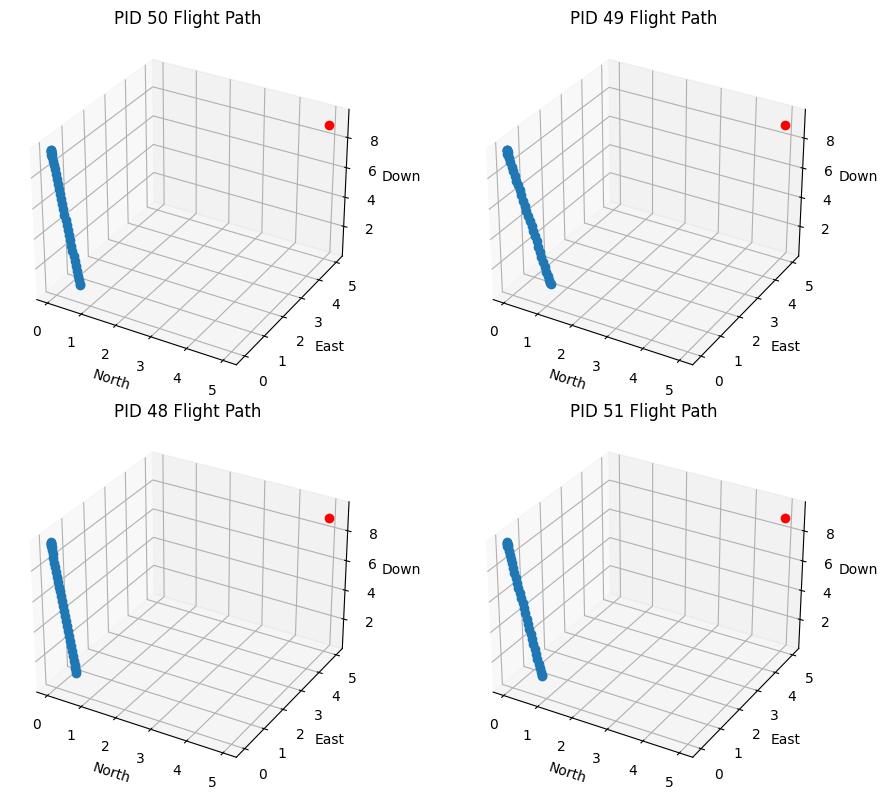

Before update: 4
After update: 4
<----------------------- EPOCH 13 ------------------------->
starting instance 52 on port 14612
starting instance 53 on port 14613
starting instance 54 on port 14614
starting instance 55 on port 14615
instance 54 - Heartbeat Recieved!
instance 55 - Heartbeat Recieved!
instance 53 - Heartbeat Recieved!
instance 52 - Heartbeat Recieved!
instance 54 - arming throttle in GUIDED mode.
Basic pre-arm checks
Setting vehicle to GUIDED mode
instance 55 - arming throttle in GUIDED mode.
Basic pre-arm checks
Setting vehicle to GUIDED mode
instance 53 - arming throttle in GUIDED mode.
Basic pre-arm checks
Setting vehicle to GUIDED mode
instance 52 - arming throttle in GUIDED mode.
Basic pre-arm checks
Setting vehicle to GUIDED mode
instance 54 - sending takeoff command
COMMAND_ACK {command : 410, result : 4, progress : 0, result_param2 : 0, target_system : 0, target_component : 0}
instance 53 - sending takeoff command
instance 52 - sending takeoff command
instance 5

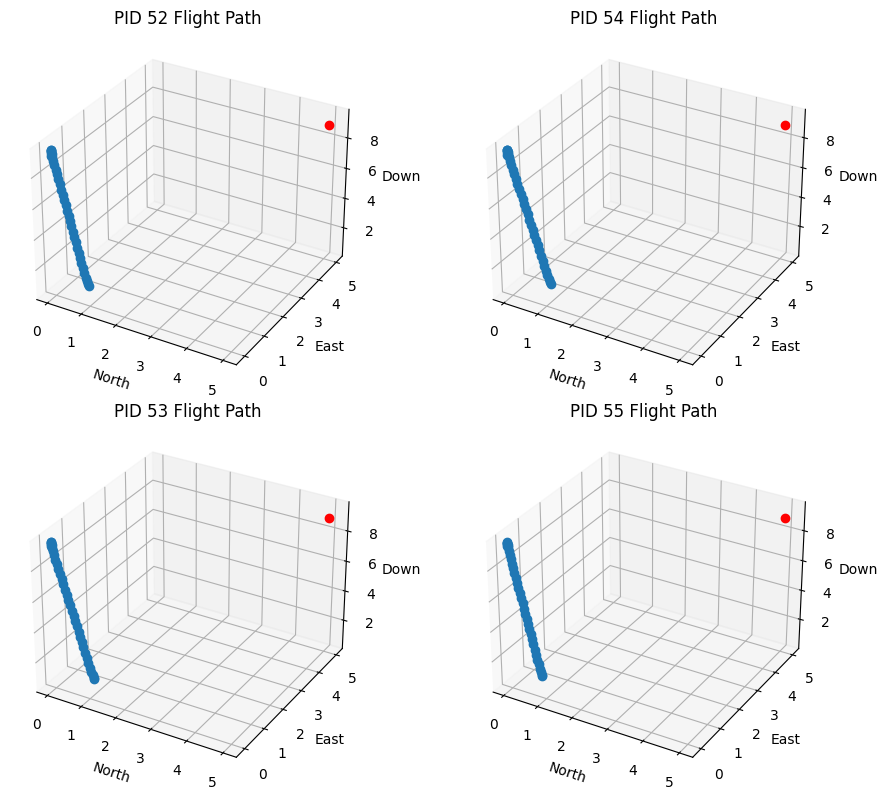

Before update: 4
After update: 4
<----------------------- EPOCH 14 ------------------------->
starting instance 56 on port 14616
starting instance 57 on port 14617
starting instance 58 on port 14618
starting instance 59 on port 14619
instance 56 - Heartbeat Recieved!instance 57 - Heartbeat Recieved!

instance 58 - Heartbeat Recieved!
instance 59 - Heartbeat Recieved!
instance 56 - arming throttle in GUIDED mode.instance 57 - arming throttle in GUIDED mode.
Basic pre-arm checks

Basic pre-arm checks
Setting vehicle to GUIDED mode
Setting vehicle to GUIDED mode
instance 58 - arming throttle in GUIDED mode.
Basic pre-arm checks
Setting vehicle to GUIDED mode
instance 59 - arming throttle in GUIDED mode.
Basic pre-arm checks
Setting vehicle to GUIDED mode
instance 56 - sending takeoff commandinstance 57 - sending takeoff command

instance 58 - sending takeoff command
COMMAND_ACK {command : 410, result : 4, progress : 0, result_param2 : 0, target_system : 0, target_component : 0}
instance 5

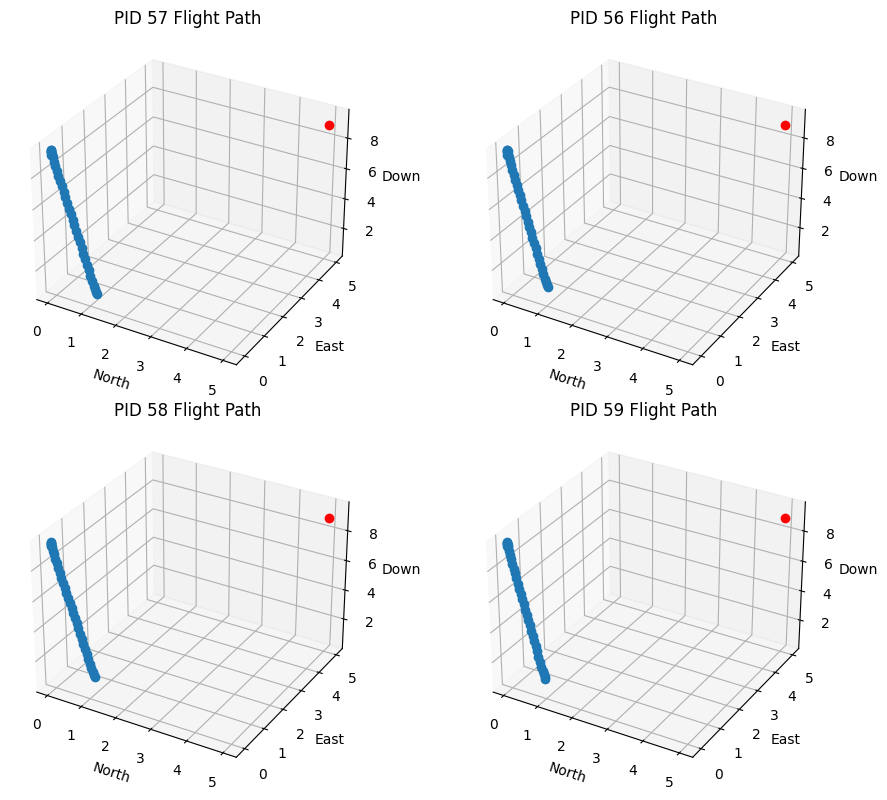

Before update: 4
After update: 4
<----------------------- EPOCH 15 ------------------------->
starting instance 60 on port 14620
starting instance 61 on port 14621
starting instance 62 on port 14622
starting instance 63 on port 14623
instance 60 - Heartbeat Recieved!
instance 62 - Heartbeat Recieved!
instance 63 - Heartbeat Recieved!
instance 61 - Heartbeat Recieved!
instance 60 - arming throttle in GUIDED mode.
Basic pre-arm checks
Setting vehicle to GUIDED mode
instance 62 - arming throttle in GUIDED mode.
Basic pre-arm checks
Setting vehicle to GUIDED mode
instance 63 - arming throttle in GUIDED mode.
Basic pre-arm checks
Setting vehicle to GUIDED mode
instance 61 - arming throttle in GUIDED mode.
Basic pre-arm checks
Setting vehicle to GUIDED mode
instance 62 - sending takeoff commandinstance 60 - sending takeoff command

COMMAND_ACK {command : 410, result : 4, progress : 0, result_param2 : 0, target_system : 0, target_component : 0}
COMMAND_ACK {command : 410, result : 4, progress

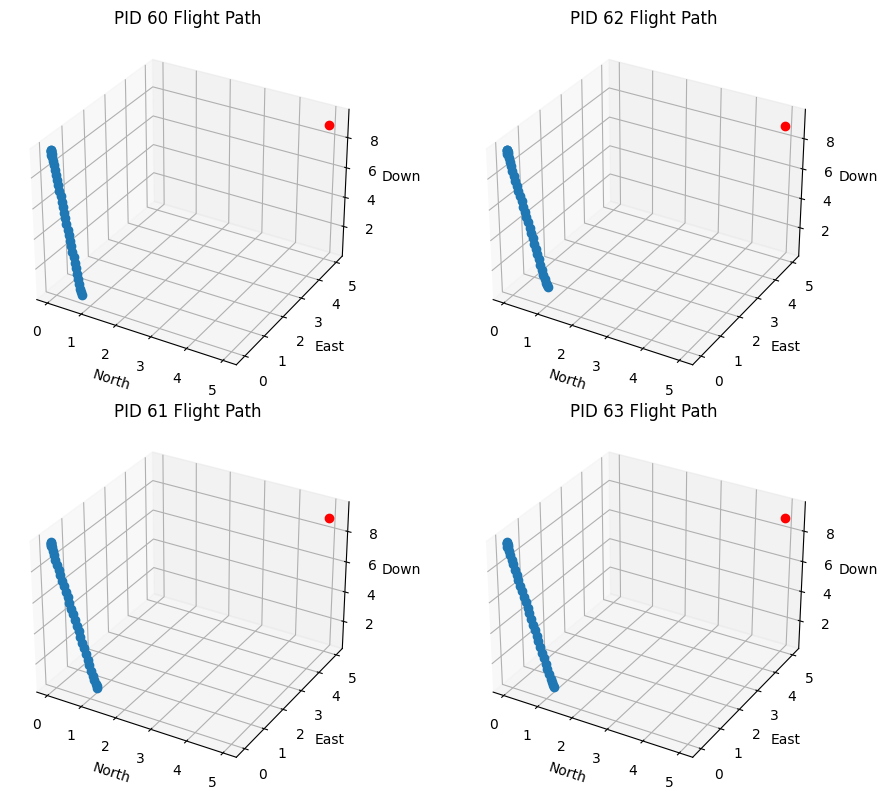

Before update: 4
After update: 4
<----------------------- EPOCH 16 ------------------------->
starting instance 64 on port 14624
starting instance 65 on port 14625
starting instance 66 on port 14626
starting instance 67 on port 14627
instance 66 - Heartbeat Recieved!instance 67 - Heartbeat Recieved!
instance 65 - Heartbeat Recieved!

instance 65 - arming throttle in GUIDED mode.instance 67 - arming throttle in GUIDED mode.
Basic pre-arm checks
instance 66 - arming throttle in GUIDED mode.
Basic pre-arm checks
Setting vehicle to GUIDED mode
Setting vehicle to GUIDED mode

Basic pre-arm checks
Setting vehicle to GUIDED mode
instance 66 - sending takeoff commandinstance 67 - sending takeoff command
instance 65 - sending takeoff command

COMMAND_ACK {command : 410, result : 4, progress : 0, result_param2 : 0, target_system : 0, target_component : 0}
COMMAND_ACK {command : 410, result : 4, progress : 0, result_param2 : 0, target_system : 0, target_component : 0}
COMMAND_ACK {command : 410, 

In [6]:
def simulate_drone(pid, out_port, network, result_dict, results_lock):
    try:
        print(f"starting instance {pid} on port {out_port}")
        start_instance(pid, out_port)
        drone_connection = connect(out_port)

        # Print heartbeat information
        while True:
            msg = drone_connection.recv_match(type='HEARTBEAT', blocking=True)
            if not msg:
                print(f"instance {pid} - No heartbeat")
            else:
                print(f"instance {pid} - Heartbeat Recieved!")
                break

        time.sleep(40)

        print(f"instance {pid} - arming throttle in GUIDED mode.")
        arm(drone_connection)

        print(f"instance {pid} - sending takeoff command")
        takeoff(drone_connection, 10)
        
        #time.sleep(8)

        path = []

        for i in range(35):
            north, east, down = get_current_position(drone_connection)

            #print(f'Instance {pid} - North: {north}, East: {east}, Down: {down}')
            
            current_pos = [north, east, down]
            path.append(current_pos)

            with torch.no_grad():
                input_tensor = torch.tensor(current_pos, dtype=torch.float32).unsqueeze(0)
                next_position = network(input_tensor).numpy()[0]  # Remove batch dimension and convert to numpy

            new_north, new_east, new_down = next_position

            print(f"Instance {pid} sending neurotic waypoint: {new_north}, {new_east}, {-new_down}")

            send_waypoint_local(drone_connection, new_north, new_east, new_down)
            time.sleep(1)
        

        print(f"stopping instance {pid}")
        stop_instance(pid)

        result_dict[pid] = path
    
    except Exception as e:
        print(f"Exception in thread {pid}: {e}")

def main():
    out_port_base = 14560
    pid_base = 0
    instance_count = 4  # Number of individuals (and simulation instances) per epoch
    epochs = 50
    target = [5, 5, 9]
    population_size = instance_count  # Assuming you want one network per instance
    mutation_rate = 0.1
    mutation_strength = 0.1

    # Initialize the population
    population = initialize_population(population_size)

    for j in range(epochs):
        threads = []
        results = {}  # Dict to store results of each instance
        results_lock = threading.Lock()  # Lock for managing access to results

        print(f"<----------------------- EPOCH {j} ------------------------->")

        for i, network in enumerate(population):
            pid = pid_base + i
            out_port = out_port_base + i

            t = threading.Thread(target=simulate_drone, args=(pid, out_port, network, results, results_lock))
            t.start()
            threads.append(t)

        for t in threads:
            t.join(timeout = 500)
            print("Thread has completed execution.")

        fitness_scores = []
        with results_lock:
            for pid, path in results.items():
                fitness = get_fitness(path, target)
                fitness_scores.append(fitness)
                print(f"Instance: {pid} fitness: {fitness}")

            plot_3d_paths(results)

        # Evolve the population
        print(f"Before update: {len(population)}")
        population = generate_new_population(population, fitness_scores, mutation_rate, mutation_strength)
        print(f"After update: {len(population)}")

        # Increment PID and out_port for the next epoch
        pid_base += instance_count
        out_port_base += instance_count

if __name__ == "__main__":
    main() 